In [1]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

In [2]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [3]:
def find_cointegrated_pairs(price_data):
    num_stocks = price_data.shape[1]
    score_matrix = np.zeros((num_stocks, num_stocks))
    pvalue_matrix = np.ones((num_stocks, num_stocks))
    stock_symbols = price_data.keys()
    cointegrated_pairs = []
    for stock1_idx in range(num_stocks):
        for stock2_idx in range(stock1_idx+1, num_stocks):
            stock1_prices = price_data[stock_symbols[stock1_idx]]
            stock2_prices = price_data[stock_symbols[stock2_idx]]
            cointegration_result = coint(stock1_prices, stock2_prices)
            cointegration_score = cointegration_result[0]
            cointegration_pvalue = cointegration_result[1]
            score_matrix[stock1_idx, stock2_idx] = cointegration_score
            pvalue_matrix[stock1_idx, stock2_idx] = cointegration_pvalue
            if cointegration_pvalue < 0.05:
                cointegrated_pairs.append((stock_symbols[stock1_idx], stock_symbols[stock2_idx]))
    return score_matrix, pvalue_matrix, cointegrated_pairs

In [4]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2019, 1, 1)

stock_tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']


stock_prices = yf.download(stock_tickers, start_date, end_date)['Close']
stock_prices.tail()

[*********************100%***********************]  11 of 11 completed


Ticker,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2018-12-24,35.060497,205.160004,16.650000,23.619232,15.919371,77.767975,21.451321,88.722130,38.761757,46.309410,213.224747
2018-12-26,37.529507,222.949997,17.900000,25.164335,16.699741,80.529648,22.324144,94.782715,40.486927,48.303345,223.997879
2018-12-27,37.285946,225.139999,17.490000,25.326973,16.740803,82.257500,22.491993,95.367081,40.831966,48.415554,225.717636
2018-12-28,37.305050,223.130005,17.820000,25.516731,16.707949,81.715309,22.450031,94.622490,40.695766,49.037045,225.426422
2018-12-31,37.665619,226.240005,18.459999,25.363121,16.806524,82.177979,22.584307,95.734703,40.995388,49.123367,227.400909


[('ADBE', 'MSFT'), ('EBAY', 'ORCL'), ('IBM', 'JNPR'), ('ORCL', 'SPY')]


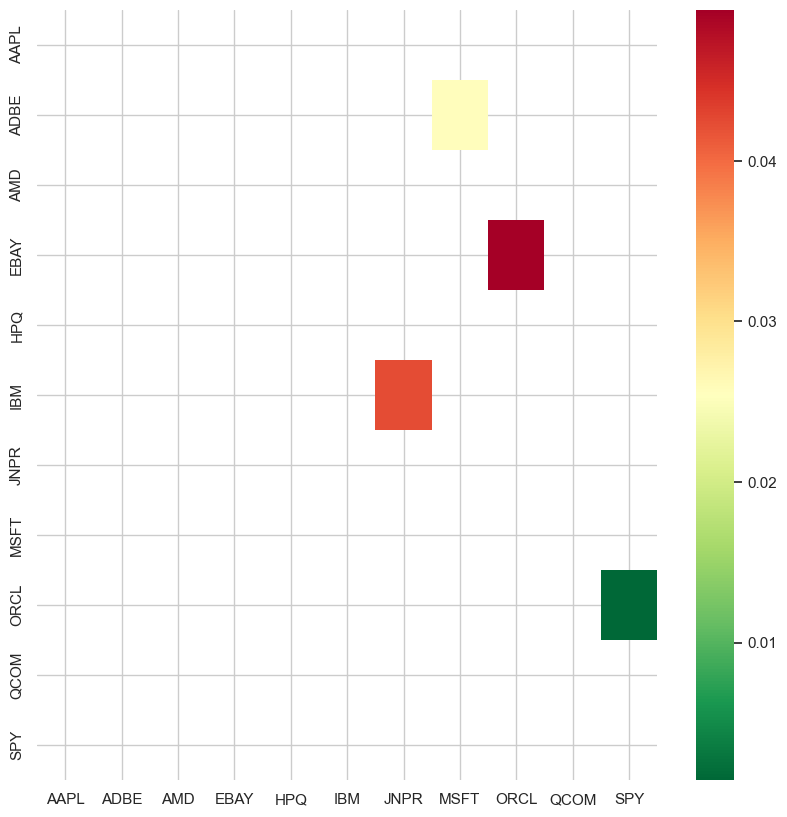

In [5]:
scores, pvalues, pairs = find_cointegrated_pairs(stock_prices)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=stock_prices.columns, yticklabels=stock_prices.columns, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)

In [6]:
adobe = stock_prices['ADBE']
microsoft = stock_prices['MSFT']

score, pvalue, _ = coint(adobe, microsoft)
pvalue

0.025639764305470637

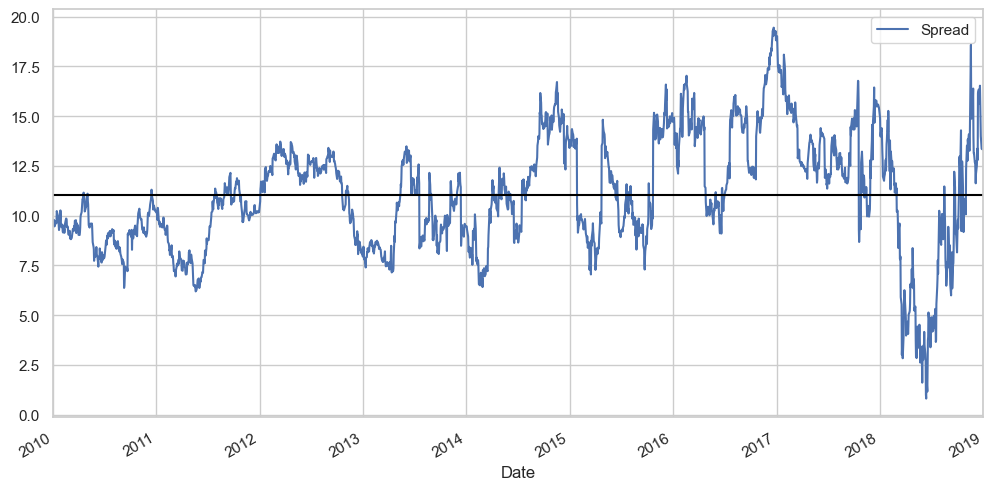

In [7]:
adobe = sm.add_constant(adobe)
results = sm.OLS(microsoft, adobe).fit()
adobe = adobe['ADBE']
beta = results.params['ADBE']

spread = microsoft - beta * adobe
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2010-01-01', '2019-01-01')
plt.legend(['Spread']);

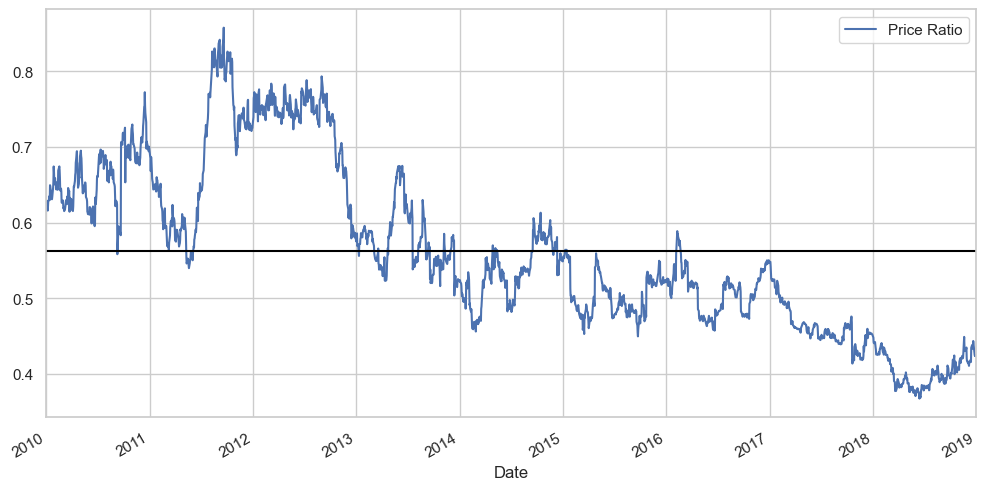

In [8]:
ratio = microsoft/adobe
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2010-01-01', '2019-01-01')
plt.legend(['Price Ratio']);

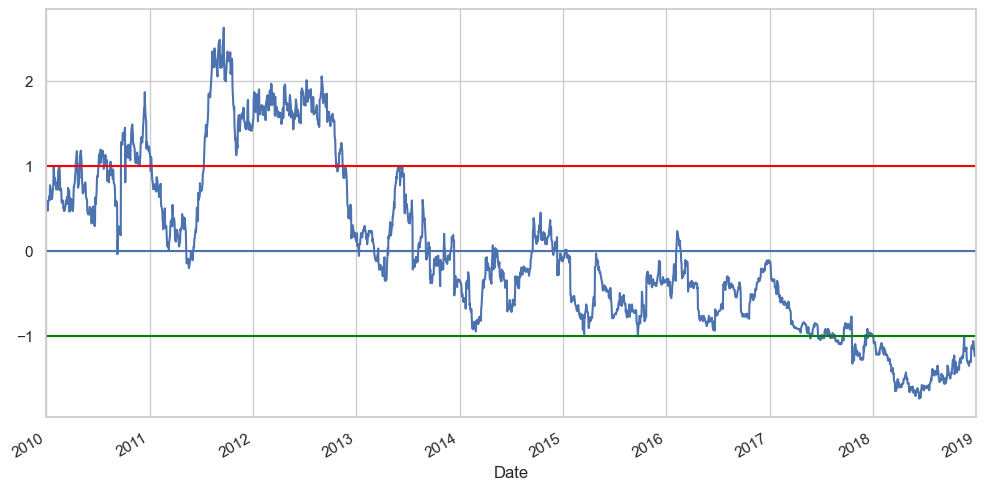

In [10]:
def calculate_zscore(data_series):
    return (data_series - data_series.mean()) / np.std(data_series)


calculate_zscore(ratio).plot(figsize=(12,6))
plt.axhline(calculate_zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2010-01-01', '2019-01-01')
plt.show()

In [12]:
price_ratios = stock_prices['ADBE'] / stock_prices['MSFT']
print(len(price_ratios) * .70 )

1584.8


In [13]:
price_ratios_train = price_ratios[:1584]
price_ratios_test = price_ratios[1584:]

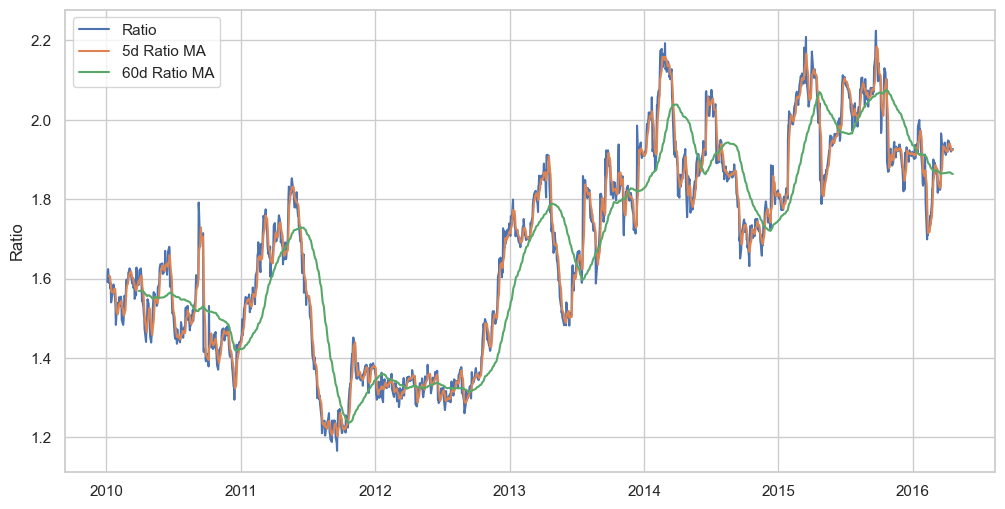

In [14]:
ratios_ma5 = price_ratios_train.rolling(window=5, center=False).mean()
ratios_ma60 = price_ratios_train.rolling(window=60, center=False).mean()
std_60 = price_ratios_train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_ma5 - ratios_ma60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(price_ratios_train.index, price_ratios_train.values)
plt.plot(ratios_ma5.index, ratios_ma5.values)
plt.plot(ratios_ma60.index, ratios_ma60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

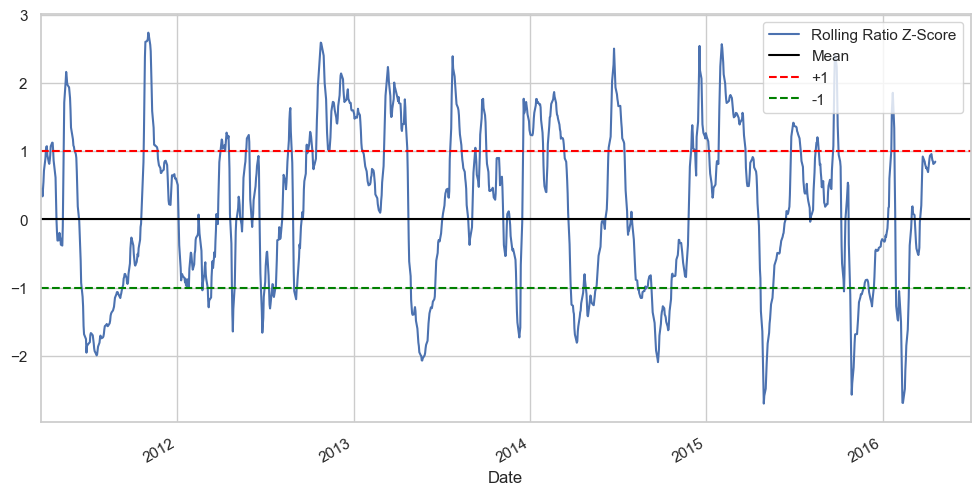

In [16]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2011-03-25', '2016-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio Z-Score', 'Mean', '+1', '-1'])
plt.show()

In [23]:
length_scores = [trade(stock_prices['ADBE'].iloc[:1584],
                stock_prices['MSFT'].iloc[:1584], l, 5)
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)


Best window length: 252


In [24]:
length_scores2 = [trade(stock_prices['ADBE'].iloc[1584:],
                  stock_prices['MSFT'].iloc[1584:],l,5)
                  for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])
# Find the best window length based on this dataset,
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

252 day window: -240.4771506068891
219 day window: 2943.0254923806397


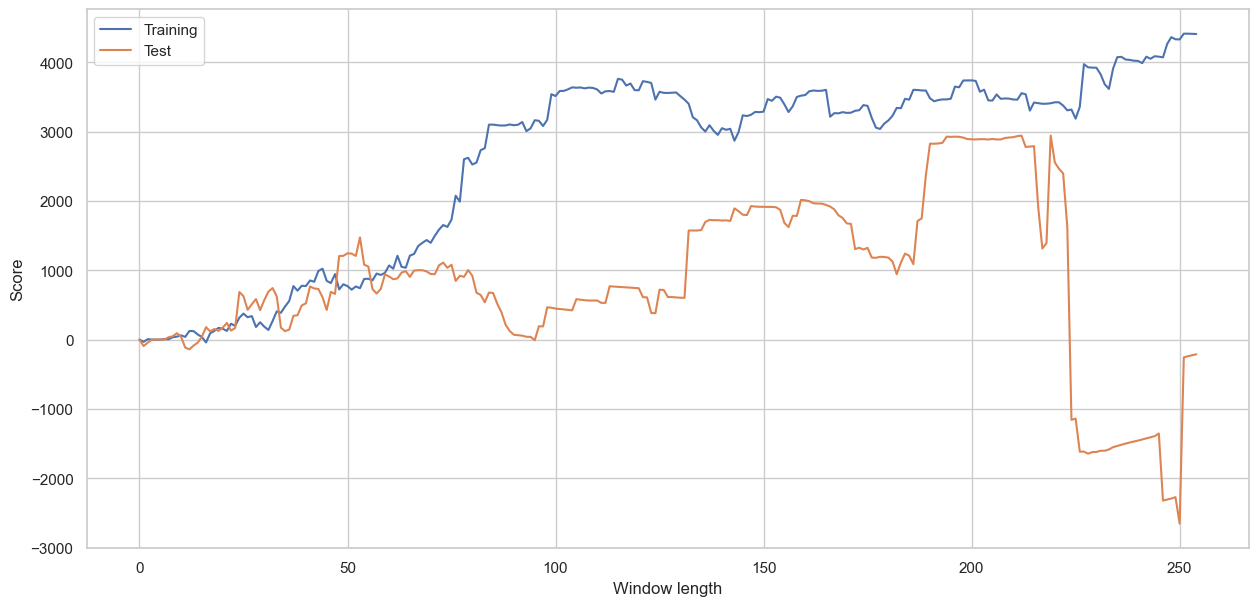

In [25]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()

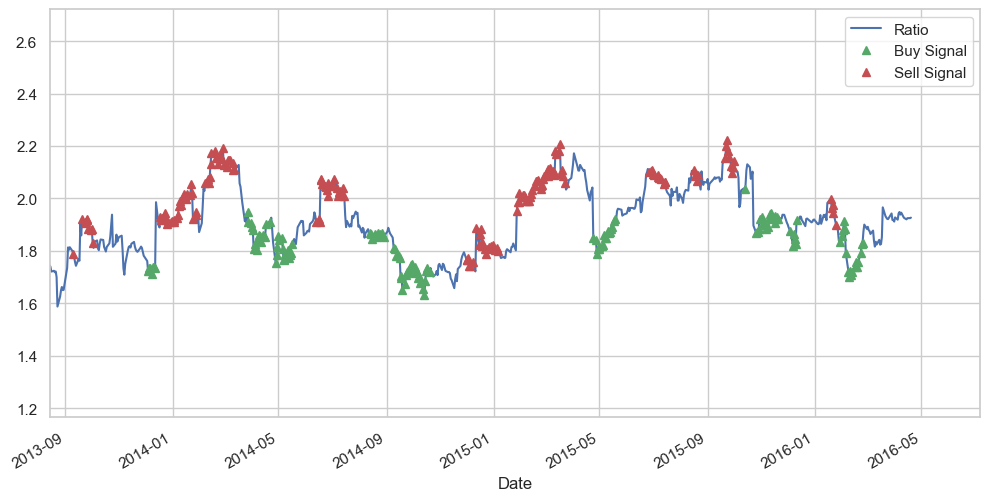

In [28]:
plt.figure(figsize=(12,6))

price_ratios_train[160:].plot()
buy = price_ratios_train.copy()
sell = price_ratios_train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, price_ratios.min(), price_ratios.max()))
plt.xlim('2013-08-15','2016-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

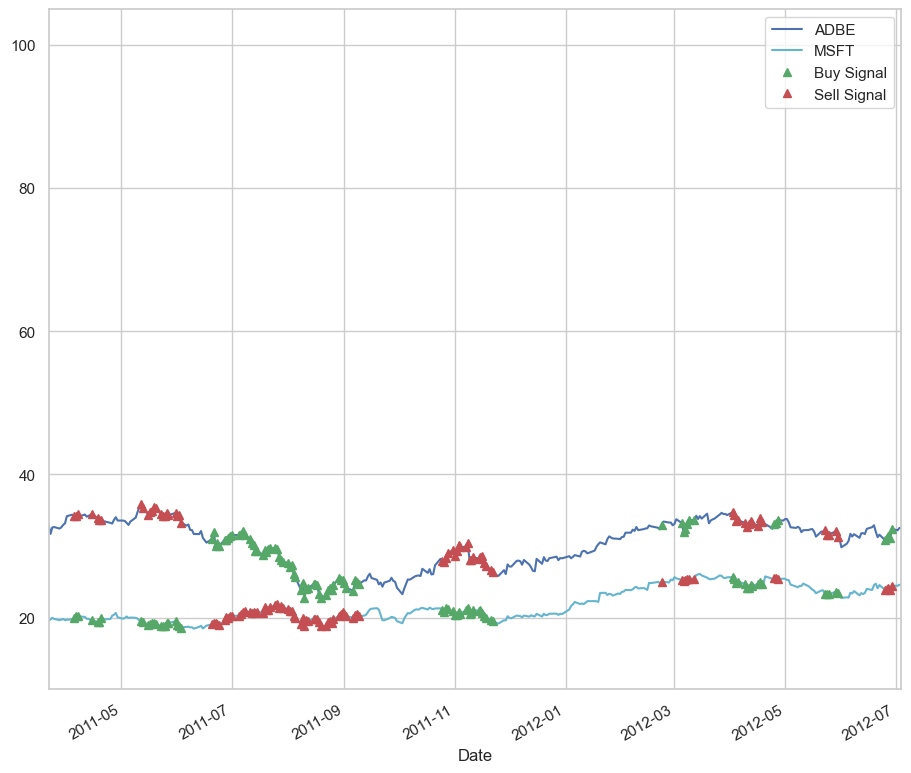

In [29]:
plt.figure(figsize=(11,10))
S1 = stock_prices['ADBE'].iloc[:881]
S2 = stock_prices['MSFT'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(10, 105)
plt.xlim('2011-03-22', '2012-07-04')

plt.legend(['ADBE', 'MSFT', 'Buy Signal', 'Sell Signal'])
plt.show()

In [22]:
def trade(S1, S2, window1, window2):

    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))


    return money

In [30]:
trade(stock_prices  ['ADBE'].iloc[881:], stock_prices['MSFT'].iloc[881:],219, 5)

6254.801832859303